In [249]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.svm import SVC
from sklearn.datasets import make_classification
# !pip install dython
from dython.nominal import associations
from matplotlib import colors as mcolors
from scipy.stats import chi2_contingency

In [232]:
df0 = pd.read_csv(r"C:\Users\Katia\Documents\UofT\STATS\final_project\universitydataset.csv")
vars_mapping = pd.read_csv(r"C:\Users\Katia\Documents\UofT\STATS\final_project\variables_mapping.csv")

In [233]:
df0 = df0[df0['Target'] != 'Enrolled'].reset_index(drop=True) # Only want graduated and dropout outcomes

# Transform output into binary
# df0['Target Num'] = None
df0.loc[df0['Target'] == 'Graduate','Target'] = 0
df0.loc[df0['Target'] == 'Dropout','Target'] = 1

rename_cols = {"Mother's qualification":'Mothers qualification',
                    "Father's qualification": 'Fathers qualification',
                    "Mother's occupation":'Mothers occupation',    
                    "Father's occupation":'Fathers occupation',
                    "Nacionality":'Nationality'}

df0.rename(columns= rename_cols, inplace=True)
vars_mapping.rename(columns= rename_cols, inplace=True)

In [234]:
relabel_occupation = {1:10,	16:4,	31:5,	6:5,	21:9,	36:1,	11:4,	26:7,	41:1,	
                    2:6,	17:6,	32:5,	7:2,	22:7,	37:1,	12:11,	27:3,	42:1,	
                    3:7,	18:5,	33:5,	8:1,	23:7,	38:1,	13:11,	28:7,	43:8,	
                    4:1,	19:7,	34:2,	9:1,	24:3,	39:1,	14:4,	29:3,	44:8,	
                    5:3,	20:7,	35:2,	10:8,	25:3,	40:1,	15:4,	30:5,	45:5,	46:8}


relabel_qualification = {1:4,	6:6,	11:3,	16:7,	21:2,	26:2,	31:7,
2:6,	7:3,	12:3,	17:7,	22:7,	27:2,	32:7,
3:6,	8:3,	13:7,	18:2,	23:7,	28:2,	33:6,
4:6,	9:2,	14:2,	19:3,	24:8,	29:7,	34:6,
5:6,	10:3,	15:7,	20:2,	25:1,	30:5}

df0.replace(to_replace={'Mothers occupation':relabel_occupation}, inplace=True)
df0.replace(to_replace={'Fathers occupation':relabel_occupation}, inplace=True)

df0.replace(to_replace={'Mothers qualification':relabel_qualification}, inplace=True)
df0.replace(to_replace={'Fathers qualification':relabel_qualification}, inplace=True)

In [325]:
# Split variables into categories to apply the corresponding correlation method
cat_vars = ['Marital status', 'Application mode', 'Course', 'Previous qualification', 'Nationality',
              'Mothers qualification', 'Fathers qualification', 'Mothers occupation', 'Fathers occupation',
              'Daytime/evening attendance', 'Displaced','Tuition fees up to date','Gender', 
              'Scholarship holder', 'International', 'Educational special needs', 'Debtor', 'Target']

for i in cat_vars:
    df0[i] = df0[i].astype(float)
    
binary_vars = ['Daytime/evening attendance', 'Displaced','Tuition fees up to date','Gender', 
              'Scholarship holder', 'International', 'Educational special needs', 'Debtor']

cont_vars = ['Age at enrollment','Application order','Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd sem (grade)',
       'Curricular units 2nd sem (without evaluations)', 
       'Unemployment rate', 'Inflation rate', 'GDP']


print("# categorical variables: ",len(cat_vars))
print("# continuous variables: ", len(cont_vars))

# categorical variables:  18
# continuous variables:  17


### Plot: Continous Data

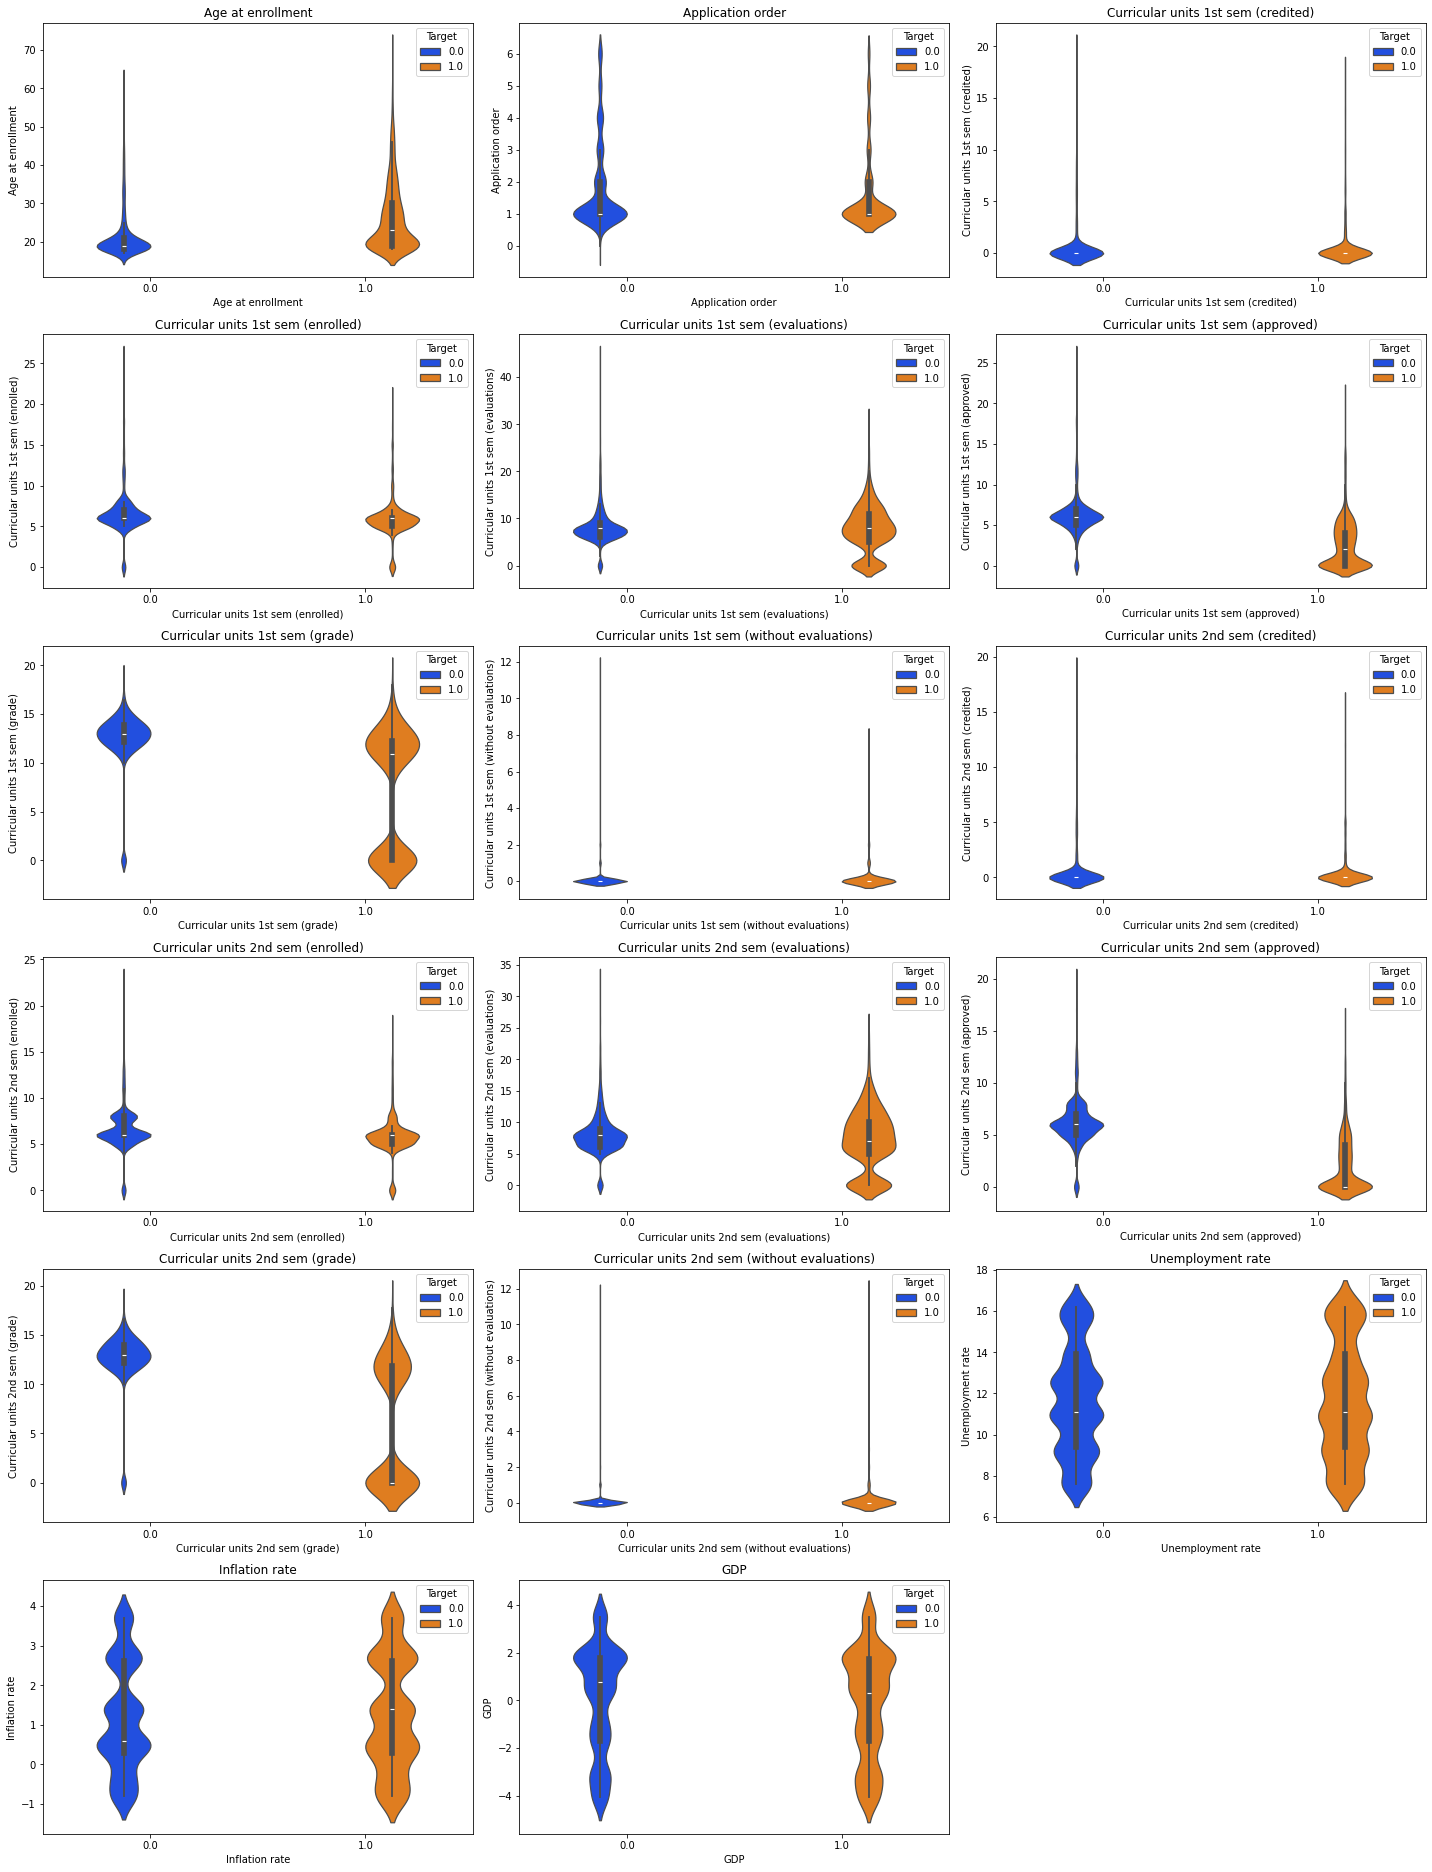

In [236]:
#  Continuous Data
a = 7  # number of rows
b = 3  # number of columns
c = 1  # initialize plot counter

fig = plt.figure(figsize = (20,30))


for i in cont_vars:
    df0_ = df0.explode(i)
    df0_[i] = df0_[i].astype('float')
    plt.subplot(a, b, c)
    plt.title('{}'.format(i))
    plt.xlabel(i)
    sns.violinplot(
        data=df0_,
        x="Target",
        y=i,
        dodge=True,   # separate plots of different colors
        width=0.5,    # width of plots
        palette = "bright",
        hue = 'Target'
       )
    c = c + 1

plt.tight_layout()
plt.show()

### Plot: Categorical Data

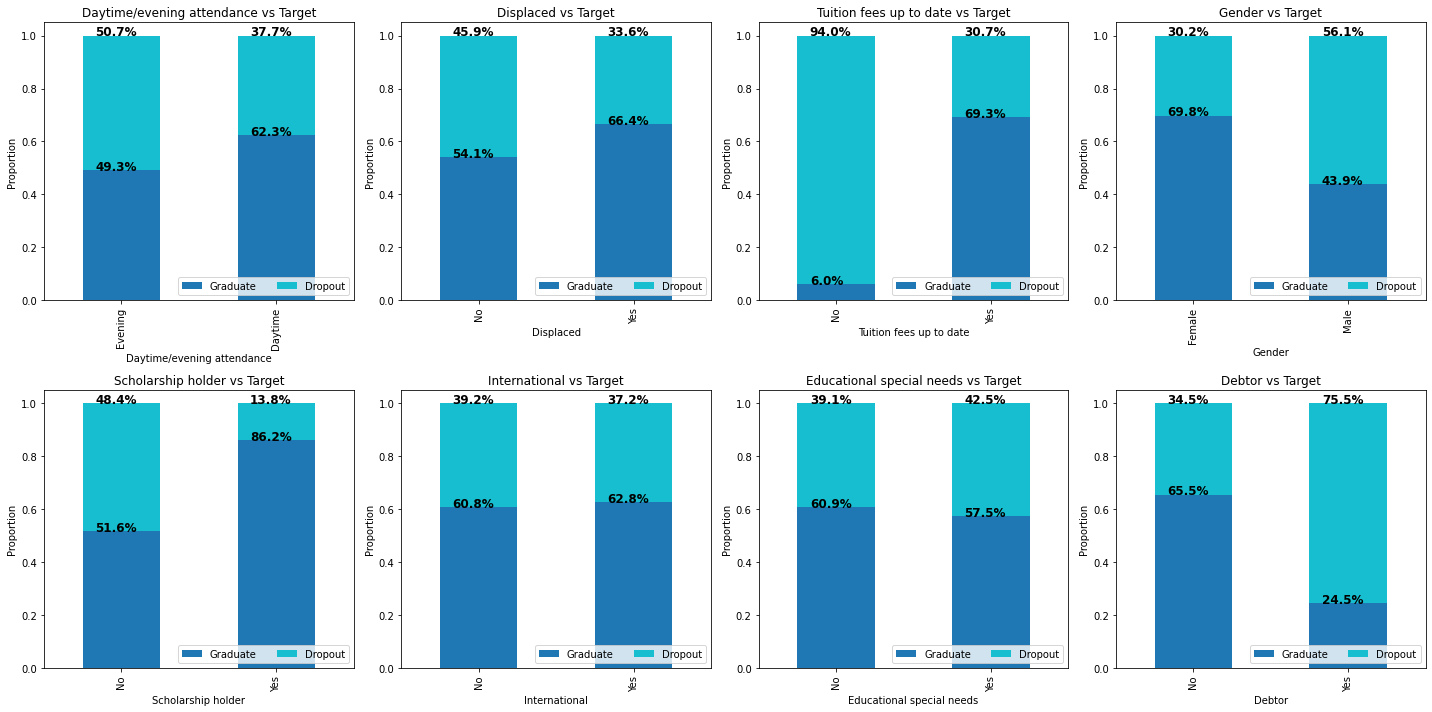

In [334]:
a = 2  # number of rows
b = 4  # number of columns
c = 1  # initialize plot counter

fig = plt.figure(figsize = (20,10))


for i in binary_vars:

    df1 = df0.loc[:,['Target', i]]

    cross_tab_prop = pd.crosstab(index=df1[i],
                                 columns=df1['Target'],
                                 normalize="index")
    

    cross_tab = pd.crosstab(index=df1[i],
                            columns=df1['Target'])
    
    cross_tab_prop.plot(kind='bar', 
                        stacked=True, 
                        colormap='tab10', ax =plt.subplot(a, b, c)
                       )

    plt.legend(loc="lower right", ncol=2, labels = ['Graduate','Dropout'])
    plt.title('{} vs Target'.format(i))
    plt.xlabel(i)
    plt.ylabel("Proportion")
    
    if i == 'Gender': plt.xticks([0,1],['Female','Male'])
    if i == 'Daytime/evening attendance': plt.xticks([0,1],['Evening','Daytime'])
    if i not in ['Gender','Daytime/evening attendance']: plt.xticks([0,1],['No','Yes'])

    for n, x in enumerate([*cross_tab.index.values]):
        for (proportion, y_loc) in zip(cross_tab_prop.loc[x],
                                   cross_tab_prop.loc[x].cumsum()):

            plt.text(x=n - 0.17,
                     y=y_loc,
                     s=f'{np.round(proportion * 100, 1)}%', 
                     color="black",
                     fontsize=12,
                     fontweight="bold")
    c = c + 1

plt.tight_layout()
plt.show()


### T-test for Continuous vs. Target

In [198]:
diff_variance_vars = []
equal_variance_vars = []

for i in cont_vars:
    var_diff = np.round(np.absolute(df0[df0['Target']==1][i].var() - df0[df0['Target']==0][i].var()),2)
    if var_diff < 1: equal_variance_vars.append(i)
    if var_diff >= 1: diff_variance_vars.append(i)

print(diff_variance_vars)
print(equal_variance_vars)

['Age at enrollment', 'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)', 'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)']
['Application order', 'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (without evaluations)', 'Unemployment rate', 'Inflation rate', 'GDP']


In [199]:
test_results = pd.DataFrame()
p_val = 0.01
for i in equal_variance_vars:
    group1 = df0[df0['Target']==1][i]
    group2 = df0[df0['Target']==0][i]
    t_test = [stats.ttest_ind(group1, group2, axis=0, equal_var=True, alternative='two-sided')]
    t_test = pd.DataFrame(t_test)
    t_test['variable'] = i
    t_test['n1'] = len(group1)
    t_test['n2'] = len(group2)
    test_results = pd.concat([test_results,t_test])
    
for i in diff_variance_vars:
    group1 = df0[df0['Target']==1][i]
    group2 = df0[df0['Target']==0][i]
    t_test = [stats.ttest_ind(group1, group2, axis=0, equal_var=False, alternative='two-sided')]
    t_test = pd.DataFrame(t_test)
    t_test['variable'] = i
    t_test['n1'] = len(group1)
    t_test['n2'] = len(group2)
    test_results = pd.concat([test_results,t_test])
    
test_results.reset_index(drop=True, inplace=True)
test_results = test_results[['variable','n1','n2','statistic','pvalue']]
test_results.loc[test_results['pvalue']< p_val,'test_result'] = 1
test_results.loc[test_results['pvalue']>= p_val,'test_result'] = 0
test_results['t-abs'] = np.abs(test_results['statistic'])
test_results.sort_values(by='t-abs', ascending=False)

,variable,n1,n2,statistic,pvalue,test_result,t-abs
15,Curricular units 2nd sem (approved),1421,2209,-50.671268,0.000000e+00,1.0,50.671268
16,Curricular units 2nd sem (grade),1421,2209,-39.504220,1.768346e-245,1.0,39.504220
11,Curricular units 1st sem (approved),1421,2209,-39.306474,1.307655e-269,1.0,39.306474
12,Curricular units 1st sem (grade),1421,2209,-31.690690,2.399283e-175,1.0,31.690690
7,Age at enrollment,1421,2209,15.796570,1.252287e-53,1.0,15.796570
2,Curricular units 2nd sem (enrolled),1421,2209,-11.205396,1.128426e-28,1.0,11.205396
9,Curricular units 1st sem (enrolled),1421,2209,-10.122656,9.676921e-24,1.0,10.122656
14,Curricular units 2nd sem (evaluations),1421,2209,-6.666051,3.295788e-11,1.0,6.666051
3,Curricular units 2nd sem (without evaluations),1421,2209,6.217994,5.607154e-10,1.0,6.217994
0,Application order,1421,2209,-5.708720,1.229608e-08,1.0,5.708720


In [211]:
df0_names = pd.DataFrame()

for i in cat_vars:
    df0_names = pd.concat([df0_names,df0[[i]].merge(vars_mapping[['Value',i]], left_on=i, right_on='Value', suffixes=[' #', None], how='left').drop(columns=[i+" #", 'Value'])], axis = 1 )

print(len(df0_names))
print(len(df0))

3630
3630


### Chi-square Categorical vs. Target

In [267]:
df_P = pd.DataFrame({'variable':cat_vars[:-1]})

p_values=[]
for i in cat_vars[:-1]:

# Performing test for Variable: Debtor
    CrosstabResult=pd.crosstab(index=df0[i],columns=df0['Target'])

    ChiSqResult = chi2_contingency(CrosstabResult)
    p_values.append(ChiSqResult[1])

df_P['pvalue'] = p_values
p_val = 0.01
df_P.loc[df_P['pvalue']< p_val,'test_result'] = 1
df_P.loc[df_P['pvalue']>= p_val,'test_result'] = 0

df_P

,variable,pvalue,test_result
0,Marital status,3.160761e-10,1.0
1,Application mode,8.435153e-73,1.0
2,Course,3.497695e-84,1.0
3,Previous qualification,5.952453e-24,1.0
4,Nationality,3.412815e-01,0.0
5,Mothers qualification,2.877852e-16,1.0
6,Fathers qualification,2.362734e-15,1.0
7,Mothers occupation,1.202485e-19,1.0
8,Fathers occupation,2.138908e-16,1.0
9,Daytime/evening attendance,4.728747e-07,1.0


### Correlation Matrix

In [274]:
cont_vars_statistically_significant = np.array(test_results[test_results['test_result'] == 1]['variable']) 
cat_vars_statistically_significant = np.array(df_P[df_P['test_result'] == 1]['variable'])
print(cont_vars_statistically_significant)
print(len(cont_vars)-len(cont_vars_statistically_significant))
print('----------------')
print(cat_vars_statistically_significant)
print(len(cat_vars[:-1])-len(cat_vars_statistically_significant))

['Application order' 'Curricular units 1st sem (without evaluations)'
 'Curricular units 2nd sem (enrolled)'
 'Curricular units 2nd sem (without evaluations)' 'GDP'
 'Age at enrollment' 'Curricular units 1st sem (credited)'
 'Curricular units 1st sem (enrolled)'
 'Curricular units 1st sem (evaluations)'
 'Curricular units 1st sem (approved)' 'Curricular units 1st sem (grade)'
 'Curricular units 2nd sem (credited)'
 'Curricular units 2nd sem (evaluations)'
 'Curricular units 2nd sem (approved)' 'Curricular units 2nd sem (grade)']
2
----------------
['Marital status' 'Application mode' 'Course' 'Previous qualification'
 'Mothers qualification' 'Fathers qualification' 'Mothers occupation'
 'Fathers occupation' 'Daytime/evening attendance' 'Displaced'
 'Tuition fees up to date' 'Gender' 'Scholarship holder' 'Debtor']
3


In [275]:
def create_custom_cmap():
    # Define colors for negative and positive values
    neg_color = plt.cm.summer(0.5)
    pos_color = plt.cm.summer(0.5)

    # Create a colormap
    cmap = mcolors.LinearSegmentedColormap.from_list(
        'custom_cmap',
        [   (*neg_color[:-1], 1),  
            (*neg_color[:-1], 0.8),  
            (1, 1, 1, 1),            
            (*pos_color[:-1], 0.8), 
            (*pos_color[:-1], 1)  ],
        N=256  # Number of steps in the colormap
    )
    return cmap

cmap = create_custom_cmap()

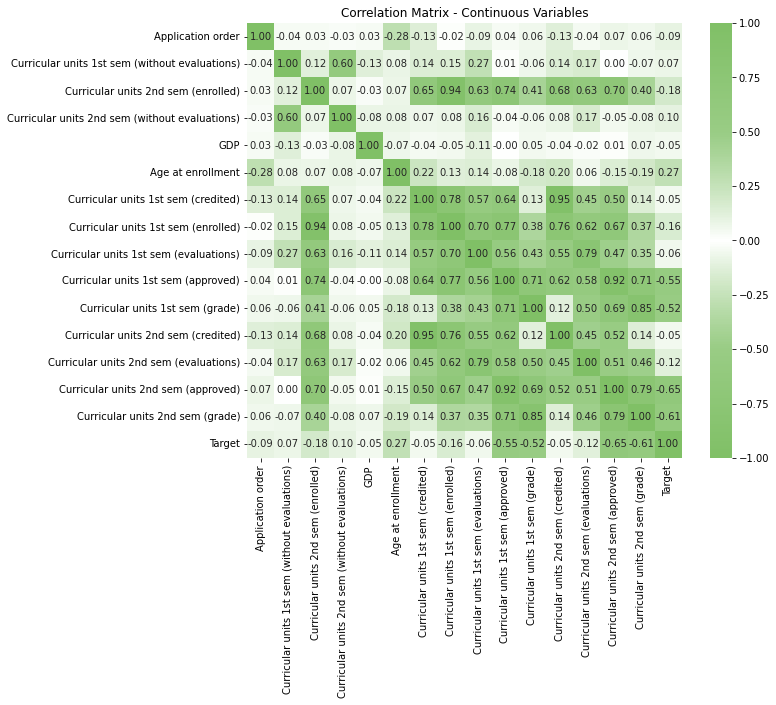

In [287]:
# Continuous Matrix
# Correlation ratio association plot
fig, ax1 = plt.subplots(figsize=(10, 8))
cor_ratio = associations(df0[np.append(cont_vars_statistically_significant, ['Target']) ], nom_num_assoc='correlation_ratio', num_num_assoc='pearson', cmap=cmap, ax=ax1, title='Correlation Matrix - Continuous Variables')
plt.show()

In [294]:
cont_corr_matrix = cor_ratio.get('corr')
df_strong_cont_vars = cont_corr_matrix[np.abs(cont_corr_matrix['Target'])>= 0.3]
df_strong_cont_vars[df_strong_cont_vars.index]

,Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Target
Curricular units 1st sem (approved),1.000000,0.710157,0.916334,0.709368,-0.554881
Curricular units 1st sem (grade),0.710157,1.000000,0.691907,0.845864,-0.519927
Curricular units 2nd sem (approved),0.916334,0.691907,1.000000,0.786838,-0.653995
Curricular units 2nd sem (grade),0.709368,0.845864,0.786838,1.000000,-0.605350
Target,-0.554881,-0.519927,-0.653995,-0.605350,1.000000


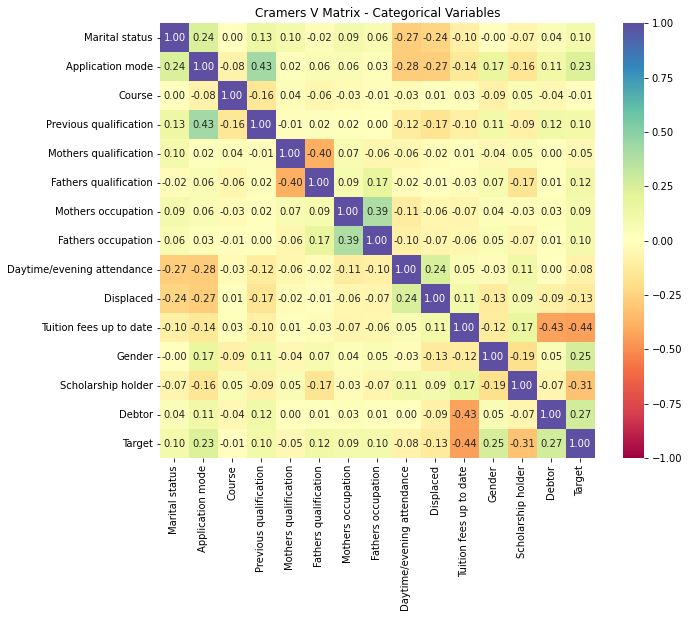

In [292]:
# Categorical Matrix
# Generate Cramer's V association plot
fig, ax2 = plt.subplots(figsize=(10, 8))
cramers_v = associations(df0[np.append(cat_vars_statistically_significant, ['Target']) ], nom_nom_assoc='cramer', cmap='Spectral', ax=ax2, title='Cramers V Matrix - Categorical Variables')
plt.show()


In [ ]:
cat_vars_statistically_significant

In [295]:
cat_corr_matrix = cramers_v.get('corr')
cat_corr_matrix[np.abs(cat_corr_matrix['Target'])>= 0.3][['Tuition fees up to date','Scholarship holder']]

,Tuition fees up to date,Scholarship holder
Tuition fees up to date,1.000000,0.169590
Scholarship holder,0.169590,1.000000
Target,-0.442138,-0.313018


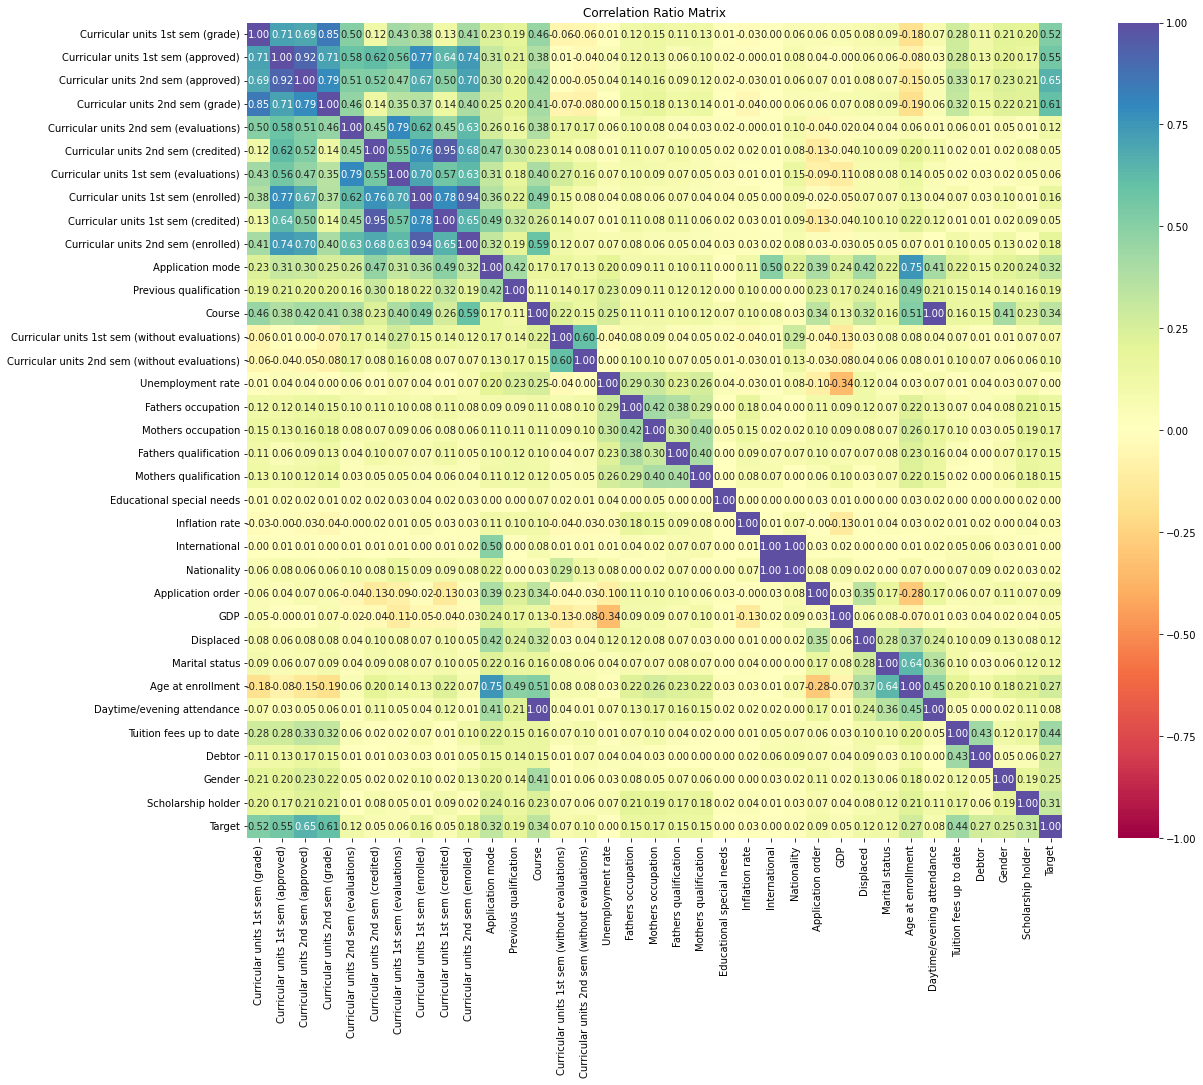

In [297]:
fig, ax2 = plt.subplots(figsize=(20,15))
associations(df0,
            nominal_columns=cat_vars, 
            numerical_columns=cont_vars,
            nom_nom_assoc='cramer', 
            cmap='Spectral', 
            ax=ax2, 
            clustering=True,
            title='Correlation Ratio Matrix')
plt.show()

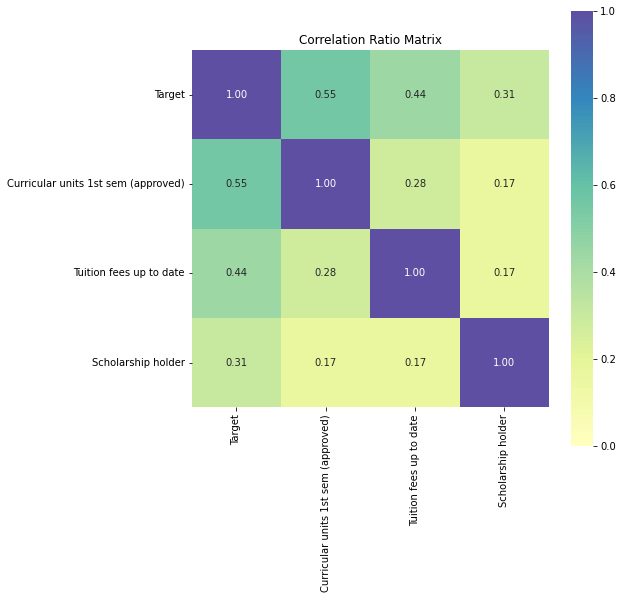

In [320]:
fig, ax2 = plt.subplots(figsize=(8,8))
cat_final_vars = ['Tuition fees up to date','Scholarship holder','Target']
cont_final_vars = ['Curricular units 1st sem (approved)']
associations(df0[np.append(cat_final_vars,cont_final_vars)],
            nominal_columns=cat_final_vars, 
            numerical_columns=cont_final_vars,
            nom_nom_assoc='cramer', 
            cmap='Spectral', 
            ax=ax2, 
            clustering=True,
            title='Correlation Ratio Matrix')
plt.show()

In [314]:
df_cleaned = df0[cat_final_vars + cont_final_vars+['Target']]
df_cleaned

,Tuition fees up to date,Scholarship holder,Curricular units 1st sem (approved),Target
0,1.0,0.0,0,1.0
1,0.0,0.0,6,0.0
2,0.0,0.0,0,1.0
3,1.0,0.0,6,0.0
4,1.0,0.0,5,0.0
...,...,...,...,...
3625,1.0,0.0,5,0.0
3626,0.0,0.0,6,1.0
3627,1.0,1.0,7,1.0
3628,1.0,1.0,5,0.0


In [315]:
df_cleaned.to_csv('df_cleaned.csv', index=False)